In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf

from core.functions import heatmap_corr
from core.functions import logistic_reg

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/raw/motor_vehicle_insurance_data.csv', sep=';', parse_dates=['Date_start_contract', 'Date_last_renewal',
        'Date_next_renewal','Date_birth', 'Date_driving_licence', 'Date_lapse'], dayfirst=True)
display(df.head())
display(df.shape)

C:\Users\CLopes\AppData\Local\Temp\ipykernel_17228\3081844874.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/motor_vehicle_insurance_data.csv', sep=';', parse_dates=['Date_start_contract', 'Date_last_renewal',


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190


(105555, 30)

In [3]:
display(df.dtypes, df.isna().sum())

ID                               int64
Date_start_contract     datetime64[ns]
Date_last_renewal       datetime64[ns]
Date_next_renewal       datetime64[ns]
Date_birth              datetime64[ns]
Date_driving_licence    datetime64[ns]
Distribution_channel            object
Seniority                        int64
Policies_in_force                int64
Max_policies                     int64
Max_products                     int64
Lapse                            int64
Date_lapse              datetime64[ns]
Payment                          int64
Premium                        float64
Cost_claims_year               float64
N_claims_year                    int64
N_claims_history                 int64
R_Claims_history               float64
Type_risk                        int64
Area                             int64
Second_driver                    int64
Year_matriculation               int64
Power                            int64
Cylinder_capacity                int64
Value_vehicle            

ID                          0
Date_start_contract         0
Date_last_renewal           0
Date_next_renewal           0
Date_birth                  0
Date_driving_licence        0
Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Lapse                       0
Date_lapse              70408
Payment                     0
Premium                     0
Cost_claims_year            0
N_claims_year               0
N_claims_history            0
R_Claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Year_matriculation          0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                1764
Length                  10329
Weight                      0
dtype: int64

In [4]:
for cat_col in df.columns:
    if df[cat_col].dtype == 'object':
        df[cat_col] = df[cat_col].astype('category')

df.dtypes

ID                               int64
Date_start_contract     datetime64[ns]
Date_last_renewal       datetime64[ns]
Date_next_renewal       datetime64[ns]
Date_birth              datetime64[ns]
Date_driving_licence    datetime64[ns]
Distribution_channel          category
Seniority                        int64
Policies_in_force                int64
Max_policies                     int64
Max_products                     int64
Lapse                            int64
Date_lapse              datetime64[ns]
Payment                          int64
Premium                        float64
Cost_claims_year               float64
N_claims_year                    int64
N_claims_history                 int64
R_Claims_history               float64
Type_risk                        int64
Area                             int64
Second_driver                    int64
Year_matriculation               int64
Power                            int64
Cylinder_capacity                int64
Value_vehicle            

In [5]:
for row in range(df.shape[0]):
    if df.loc[row, 'Date_lapse'] == 'NaT':
        df.loc[row, 'Date_lapse'] = np.NaN

In [6]:
# Cria uma coluna 'Age' vazia antes do loop (logo após 'Date_birth')
pos = df.columns.get_loc('Date_birth')
df.insert(pos + 1, 'Age', np.nan)
# The age of the policyholder on the date of contract renewal
for row in range(df.shape[0]):
    birth = df.loc[row, 'Date_birth']
    ref = df.loc[row, 'Date_last_renewal']
    age = ref.year - birth.year
# Did person have already birthday this year? If not substract a year.
    if (birth.month, birth.day) > (ref.month, ref.day):
        age = age - 1
    df.loc[row, 'Age'] = age

In [7]:
time_drv_license = df['Date_last_renewal'].dt.year - df['Date_driving_licence'].dt.year
not_yet_birthday = (df['Date_last_renewal'].dt.month < df['Date_driving_licence'].dt.month) | \
((df['Date_last_renewal'].dt.month == df['Date_driving_licence'].dt.month) & (df['Date_last_renewal'].dt.day < df['Date_driving_licence'].dt.day))
time_drv_license = time_drv_license - not_yet_birthday.astype(int)
# Encontra a posição de Date_driving_licence
pos = df.columns.get_loc('Date_driving_licence')
# Insere a nova coluna ao lado da coluna Date_driving_licence
df.insert(pos + 1, 'Time_drv_license', time_drv_license)

Text(0, 0.5, '')

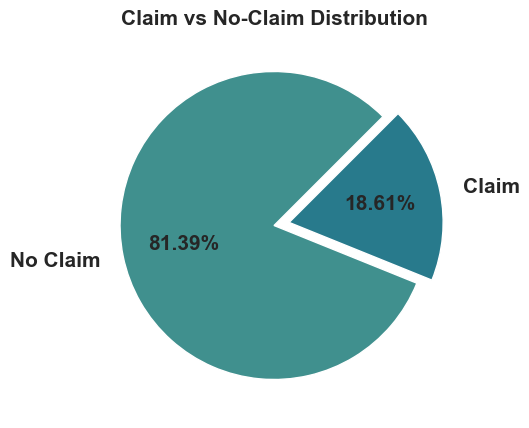

In [23]:
df['Age'] = df['Age'].astype('int64')
df['Claimed'] = (df['N_claims_year'] > 0).astype('int64')

colors = sns.color_palette("crest")[2:4]
fig, ax = plt.subplots(figsize=(6, 5))
df['Claimed'].value_counts().plot(kind = 'pie', ax=ax, labels = ['No Claim', 'Claim'], colors = colors,
                                   autopct='%1.2f%%', # inserir os porcentuais na 'fatia da pizza'
                                   explode = [0, 0.1], labeldistance=1.15, startangle=45,
                                   textprops={'fontsize':15, 'fontweight': 'bold'})
ax.set_title('Claim vs No-Claim Distribution', fontsize=15, fontweight='bold')
ax.set_ylabel('')

In [22]:
df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,59,1976-03-20,39,0,4,1,2,1,0,NaT,0,222.52,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,60,1976-03-20,40,0,4,1,2,1,0,NaT,0,213.78,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,61,1976-03-20,41,0,4,2,2,1,0,NaT,0,214.84,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,62,1976-03-20,42,0,4,2,2,1,0,NaT,0,216.99,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,61,1976-03-20,41,0,4,2,2,1,0,NaT,1,213.70,0.0,0,0,0.0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0


In [9]:
df_int = df.select_dtypes(include = 'int64').copy()
df_float = df.select_dtypes(include = 'float64').copy()
df_float['Claimed'] = df_int['Claimed']

In [10]:
df_int.describe()


,ID,Age,Time_drv_license,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Payment,N_claims_year,N_claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,N_doors,Weight,Claimed
count,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000,105555.000000
mean,26271.286789,46.827275,24.278045,6.696604,1.455649,1.837232,1.065842,0.221837,0.319180,0.394695,2.751760,2.721804,0.273895,0.123708,2004.728038,92.682611,1617.759367,4.067898,1191.262422,0.186121
std,15388.309324,12.839834,12.477684,6.263911,0.928427,1.155536,0.267807,0.464858,0.466161,1.105018,3.881621,0.614835,0.445958,0.329250,6.767037,37.012645,604.697382,1.511839,458.081834,0.389206
min,1.000000,18.000000,-3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1950.000000,0.000000,49.000000,0.000000,43.000000,0.000000
25%,12925.000000,37.000000,14.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2001.000000,75.000000,1390.000000,3.000000,1043.000000,0.000000
50%,26082.000000,46.000000,23.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,2005.000000,90.000000,1598.000000,5.000000,1205.000000,0.000000
75%,39754.000000,56.000000,34.000000,9.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.000000,3.000000,1.000000,0.000000,2008.000000,110.000000,1910.000000,5.000000,1388.000000,0.000000
max,53502.000000,98.000000,74.000000,40.000000,17.000000,17.000000,4.000000,7.000000,1.000000,25.000000,52.000000,4.000000,1.000000,1.000000,2018.000000,580.000000,7480.000000,6.000000,7300.000000,1.000000


In [11]:
display(df_int['N_claims_year'].max())
df[df['N_claims_year'] == 25]

np.int64(25)

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
45125,21987,2014-12-19,2015-12-19,2016-12-19,1972-06-06,43,2002-04-03,13,0,12,4,6,2,0,NaT,0,414.85,353.28,25,52,2.78,2,0,0,2001,116,2286,25908.6,2,D,5.899,1609,1


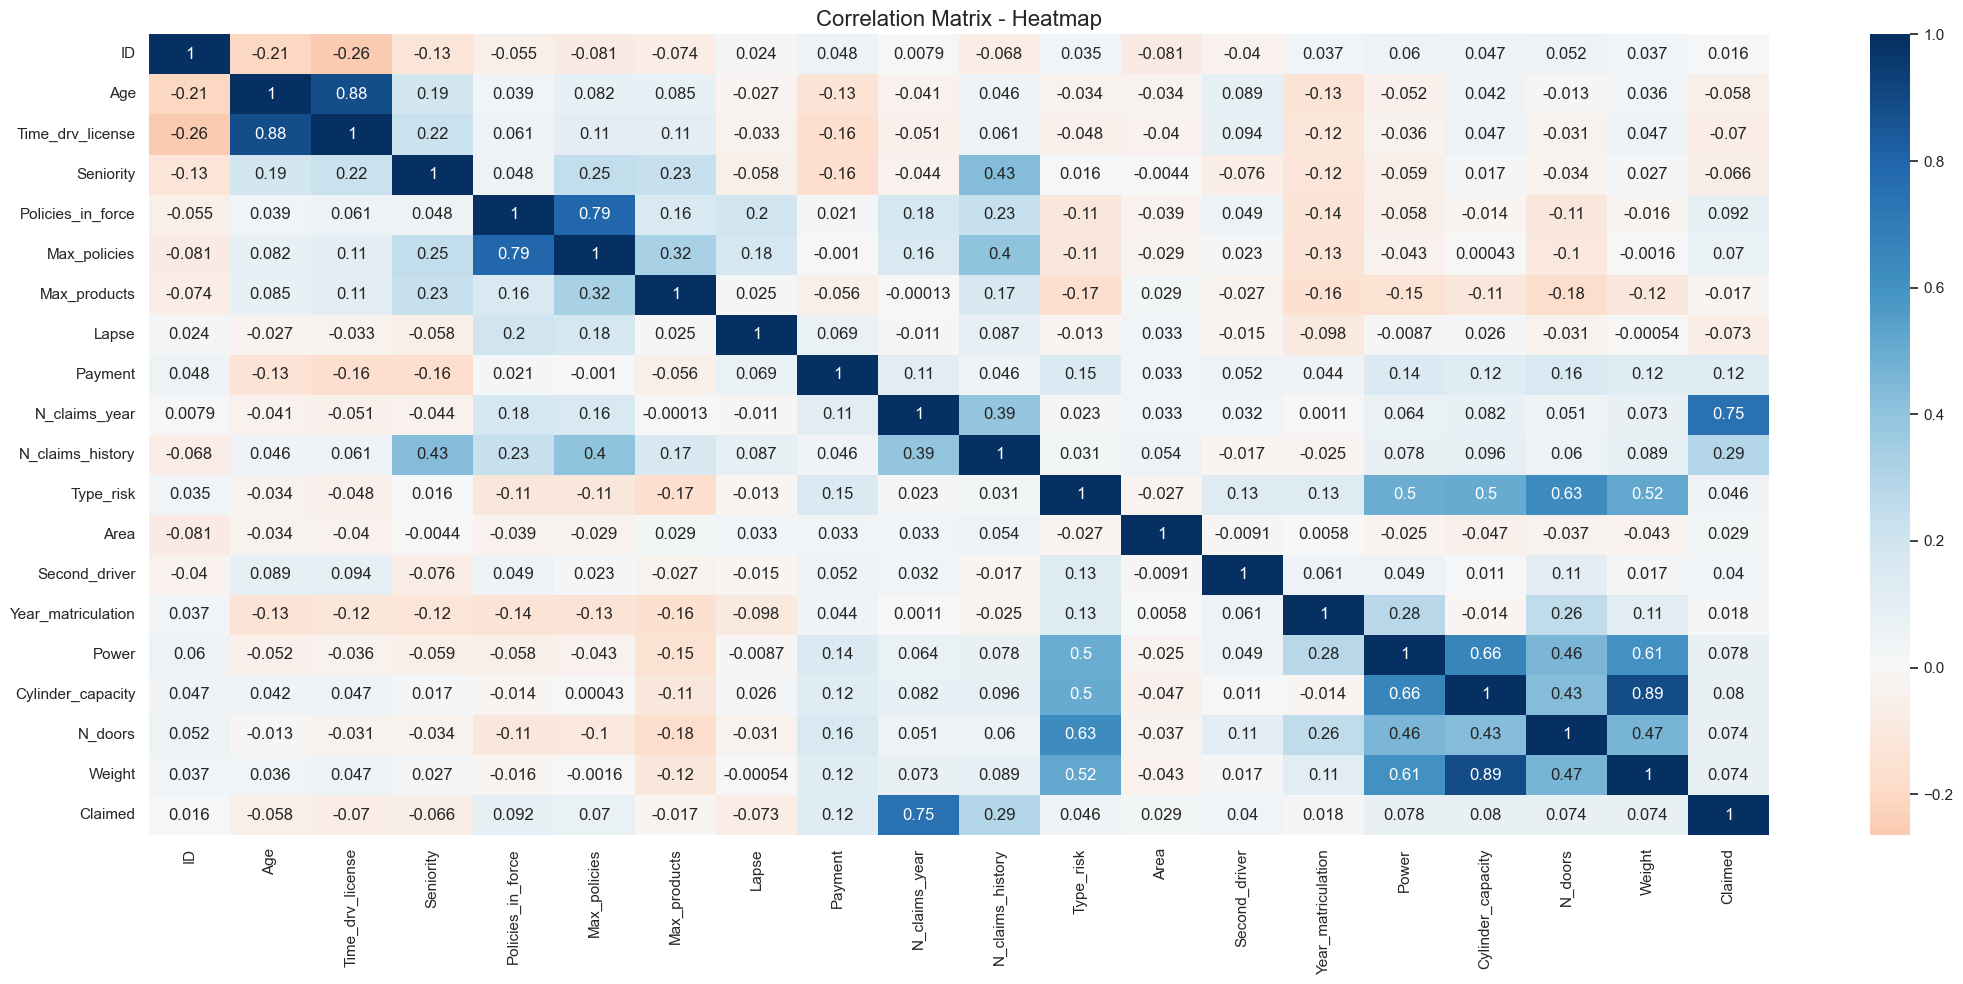

In [12]:
heatmap_corr(df_int)


In [13]:
display(df_float.describe())
display(df_float['R_Claims_history'].max())
df[df_float['R_Claims_history'] == 26.07]

,Premium,Cost_claims_year,R_Claims_history,Value_vehicle,Length,Claimed
count,105555.000000,105555.000000,105555.000000,105555.000000,95226.000000,105555.000000
mean,315.892557,153.557305,0.425194,18413.657243,4.252007,0.186121
std,140.927969,1477.112362,0.714883,9135.074235,0.393220,0.389206
min,40.140000,0.000000,0.000000,270.460000,1.978000,0.000000
25%,241.610000,0.000000,0.000000,13127.210000,3.999000,0.000000
50%,292.280000,0.000000,0.080000,17608.770000,4.230000,0.000000
75%,361.640000,0.000000,0.590000,22595.000000,4.443000,0.000000
max,2993.340000,260853.240000,26.070000,220675.800000,8.218000,1.000000


np.float64(26.07)

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
59943,29765,2018-11-02,2018-11-02,2019-11-02,1978-12-22,39,2005-02-23,13,0,1,1,2,1,0,NaT,0,225.03,99.9,2,8,26.07,3,0,0,1998,140,970,7115.92,4,D,3.43,910,1


In [14]:
display(df_float['Cost_claims_year'].max())
df[df['N_claims_history'] == 8].head(10)

np.float64(260853.24)

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Age,Date_driving_licence,Time_drv_license,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,N_claims_year,N_claims_history,R_Claims_history,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,Claimed
28,12,2016-04-05,2016-04-05,2017-04-05,1946-06-04,69,1966-10-12,49,1,3,1,1,1,0,2018-04-05,1,474.49,297.32,8,8,4.00,2,0,1,2007,70,1248,13780.00,4,D,4.159,1295,1
29,12,2016-04-05,2017-04-05,2018-04-05,1946-06-04,70,1966-10-12,50,1,3,1,1,1,0,2018-04-05,1,483.98,440.96,4,8,4.00,2,0,1,2007,70,1248,13780.00,4,D,4.159,1295,1
30,12,2016-04-05,2018-04-05,2019-04-05,1946-06-04,71,1966-10-12,51,1,3,1,1,1,1,2018-04-05,1,488.81,0.00,0,8,4.00,2,0,1,2007,70,1248,13780.00,4,D,4.159,1295,0
270,138,2013-03-04,2016-03-04,2017-03-04,1980-11-27,35,2002-11-29,13,0,1,1,2,1,1,2016-03-04,1,567.57,0.00,0,8,0.33,3,0,0,2012,110,1686,21465.00,5,D,4.419,1428,0
280,144,2016-04-21,2016-04-21,2017-04-21,1955-03-19,61,1991-04-16,25,1,5,3,3,1,0,2017-04-21,0,473.32,75.80,3,8,1.00,3,1,0,2006,65,1390,18325.00,5,D,4.282,1439,1
281,144,2016-04-21,2017-04-21,2018-04-21,1955-03-19,62,1991-04-16,26,1,5,2,3,1,2,2017-04-21,0,551.60,0.00,0,8,1.00,3,1,0,2006,65,1390,18325.00,5,D,4.282,1439,0
282,145,2018-06-25,2018-06-25,2019-06-25,1955-03-19,63,1991-04-16,27,1,5,2,3,1,0,NaT,1,306.81,4282.17,1,8,2.31,3,1,0,2006,65,1461,12012.43,5,D,3.710,995,1
504,263,2015-07-14,2016-07-14,2017-07-14,1957-07-18,58,1987-11-03,28,0,4,3,6,1,1,2017-07-14,1,268.42,114.38,7,8,1.50,3,0,1,1999,61,1998,21305.88,5,D,NaN,1490,1
505,263,2015-07-14,2017-07-14,2018-07-14,1957-07-18,59,1987-11-03,29,0,4,6,6,1,3,2017-07-14,1,254.09,182.16,3,8,1.50,3,0,1,1999,61,1998,21305.88,5,D,NaN,1490,1
506,264,2017-01-13,2017-01-13,2018-01-13,1957-07-18,59,1987-11-03,29,0,4,6,6,1,2,2017-07-13,1,274.45,89.66,5,8,2.02,2,0,0,1999,61,1870,12020.24,5,D,NaN,960,1


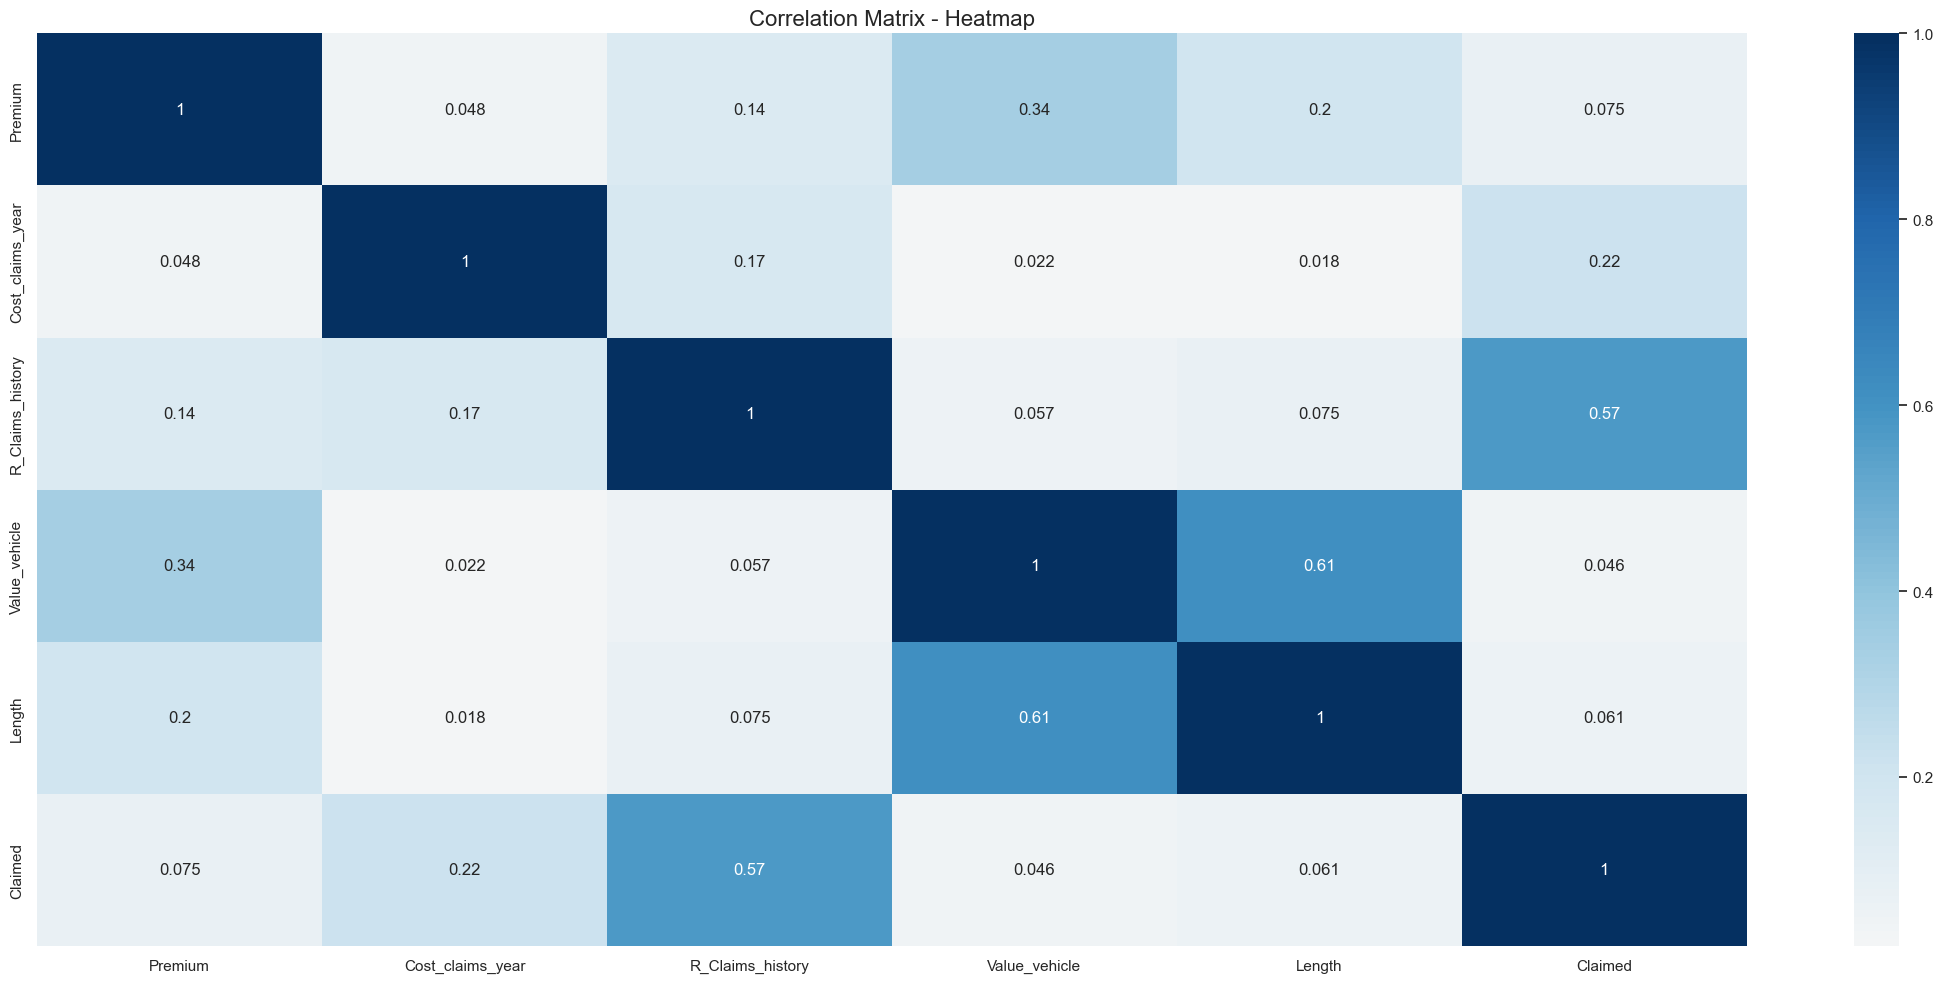

In [15]:
heatmap_corr(df_float)

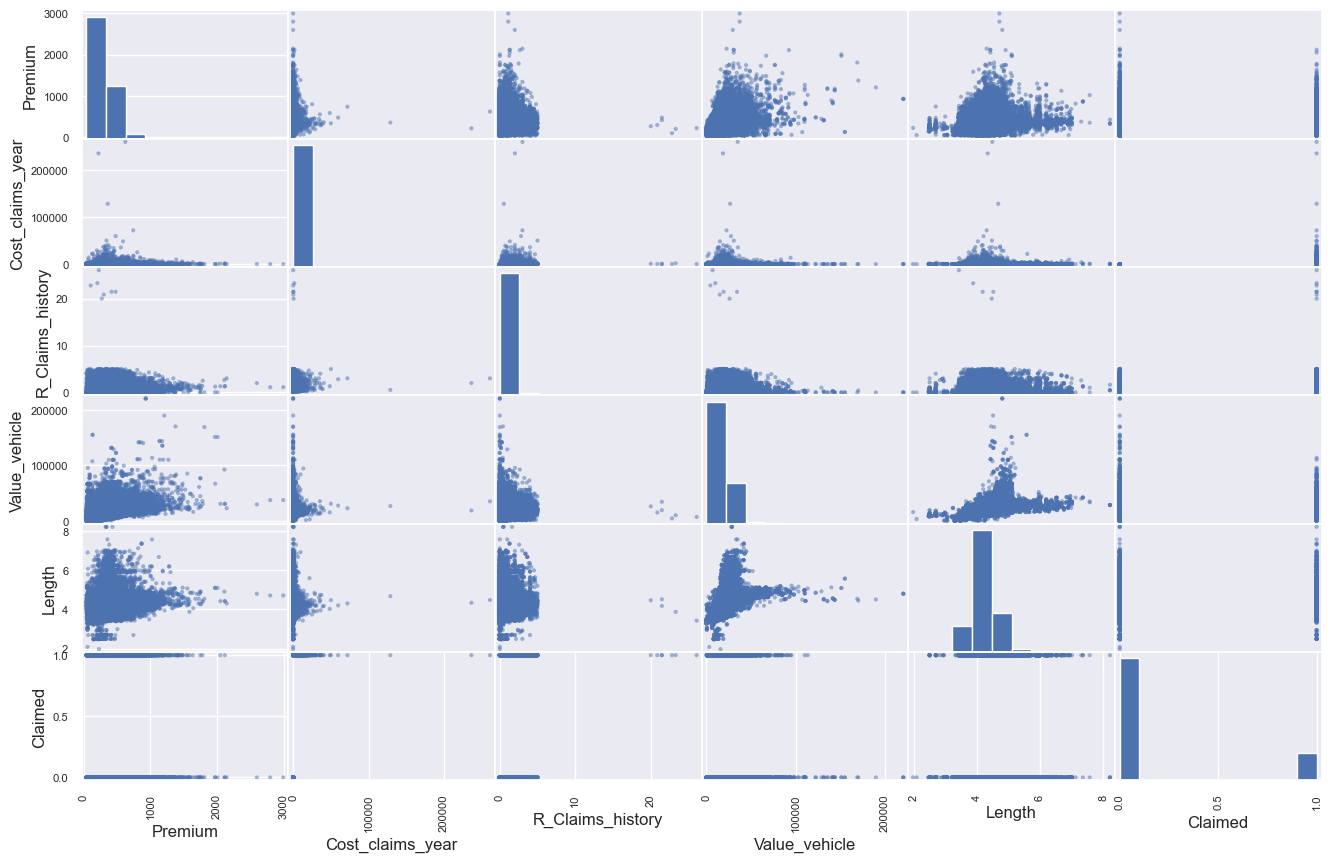

In [16]:
#fig, ax = plt.subplots(nrows = len(df_float.columns), figsize = (15, 15))
#df_float.groupby('Claimed')['R_Claims_history'].plot(kind='hist', bins = 20, ax= ax[0], xlim = [0, 1500]);
#df_float.groupby('Claimed')['R_Claims_history'].plot(kind='hist', bins = 25, xlim = [0, 5], legend = True);
pd.plotting.scatter_matrix(df_float, figsize=[16, 10]);  




In [17]:
df_float.columns

Index(['Premium', 'Cost_claims_year', 'R_Claims_history', 'Value_vehicle',
       'Length', 'Claimed'],
      dtype='object')